In [1]:
import torch
import numpy as np
from torch import nn
import torchvision
from d2l import torch as d2l
from torch.nn import functional as F
import numpy as np
import pandas as pd
import csv
import random
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# 数据参数
batch_size = 5
num_classes = 5
num_workers = 8
shuffle = True

# 模型参数
input_dim = 100
embedding_dim = 32
features_dim = 10
hidden_dim = 64

# 训练参数
lr = 0.01
num_epochs = 100
device = d2l.try_gpu()

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim,
                               out_channels=hidden_dim,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.max_pool = nn.MaxPool1d(3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.fn = nn.Linear(10,112)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.fn(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = x.view(5,64,-1,1)

        return x

In [4]:
b1 = SimpleCNN(embedding_dim, num_classes)

In [5]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [6]:
def resnet_block(in_channels, num_classes, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, num_classes,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_classes, num_classes))
    return blk

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
# 获取数据以及对应标签
features1 = []
labels1 = []
csv_filename = "../数据集/vessel_health.csv"

#读取 csv 数据内容，划分特征与标签
df = pd.read_csv(csv_filename)
features = df.iloc[:, 5:15]
labels = df.iloc[:, 0:5]

features = torch.Tensor(np.array(features)).int()
labels = torch.Tensor(np.array(labels))

#构建 dataset
dataset = TensorDataset(features, labels)
train_iter = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=shuffle,
                        num_workers=num_workers,
                        drop_last=True)

In [9]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
        y = d2l.argmax(y, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

In [10]:
def train_ch(net, train_iter, num_epochs, lr, device):

    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.MultiLabelSoftMarginLoss(reduction='mean')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                             legend=['train loss', 'train acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [11]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 5))

In [12]:
X = torch.randint(0, 5, size=(5,10))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

SimpleCNN output shape:	 torch.Size([5, 64, 56, 1])
Sequential output shape:	 torch.Size([5, 64, 56, 1])
Sequential output shape:	 torch.Size([5, 128, 28, 1])
Sequential output shape:	 torch.Size([5, 256, 14, 1])
Sequential output shape:	 torch.Size([5, 512, 7, 1])
AdaptiveAvgPool2d output shape:	 torch.Size([5, 512, 1, 1])
Flatten output shape:	 torch.Size([5, 512])
Linear output shape:	 torch.Size([5, 5])


loss 0.460, train acc 0.691
100.6 examples/sec on cuda:0


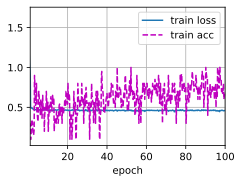

In [13]:
train_ch(net, train_iter, num_epochs, lr, device)

In [14]:
torch.save(net,'../model/model_vessel_resnet.pt')